In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.ocean_proximity = df.ocean_proximity.str.replace("<", "")

In [5]:
df = df.fillna(0)

In [6]:
df.median_house_value = df.median_house_value.apply(lambda x: np.log1p(x)) 

In [7]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,13.022766,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,12.789687,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,12.771673,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,12.740520,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,12.743154,NEAR BAY


In [8]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

In [11]:
del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

In [12]:
dict_train = df_train.to_dict(orient="records")
dict_val = df_val.to_dict(orient="records")

In [13]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

### Question 1

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [15]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [16]:
tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



### Question 2

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [19]:
y_pred= rf.predict(X_val)

In [20]:
from sklearn.metrics import mean_squared_error

In [21]:
mean_squared_error(y_val, y_pred, squared=False)

0.2456601287532493

### Question 3

In [22]:
rmses = []
for i in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred= rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    rmses.append(rmse)

[]

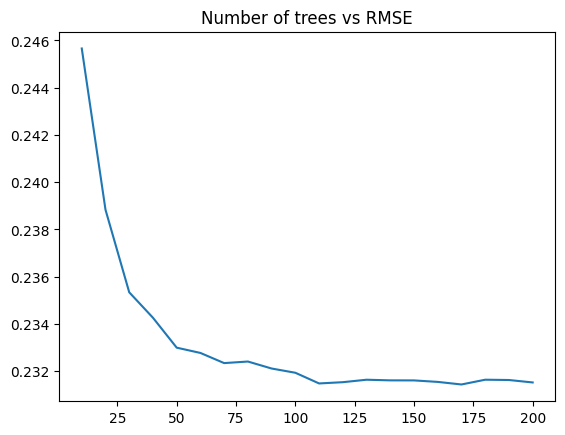

In [23]:
plt.plot(range(10, 201, 10), rmses)
plt.title("Number of trees vs RMSE")
plt.plot()

### Question 4

In [24]:
all_rmses= {}

for depth in [10, 15, 20, 25]:
    rmses = []
    for i in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=i, max_depth=depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred= rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmses.append(rmse)
        
    all_rmses[depth] = rmses

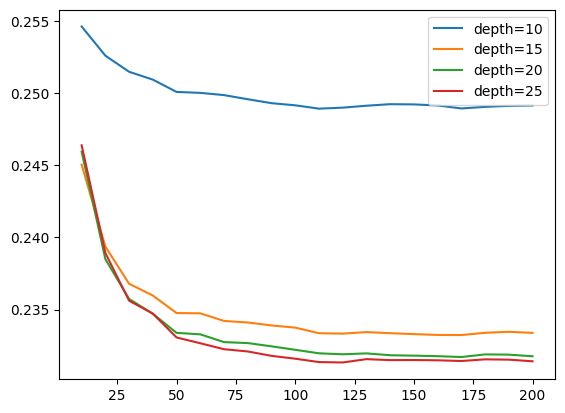

In [25]:
num_trees = list(range(10, 201, 10))
plt.plot(num_trees, all_rmses[10], label = 'depth=10')
plt.plot(num_trees, all_rmses[15], label = 'depth=15')
plt.plot(num_trees, all_rmses[20], label = 'depth=20')
plt.plot(num_trees, all_rmses[25], label = 'depth=25')
plt.legend()
plt.show()

### Question 5

In [26]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [27]:
df_feature_importance = pd.DataFrame(list(zip(dv.feature_names_, rf.feature_importances_)), columns=['feature', 'importance'])
df_feature_importance

,feature,importance
0,households,0.016387
1,housing_median_age,0.033145
2,latitude,0.101256
3,longitude,0.096470
4,median_income,0.363326
5,ocean_proximity=1H OCEAN,0.002489
6,ocean_proximity=INLAND,0.310901
7,ocean_proximity=ISLAND,0.000357
8,ocean_proximity=NEAR BAY,0.000480
9,ocean_proximity=NEAR OCEAN,0.004699


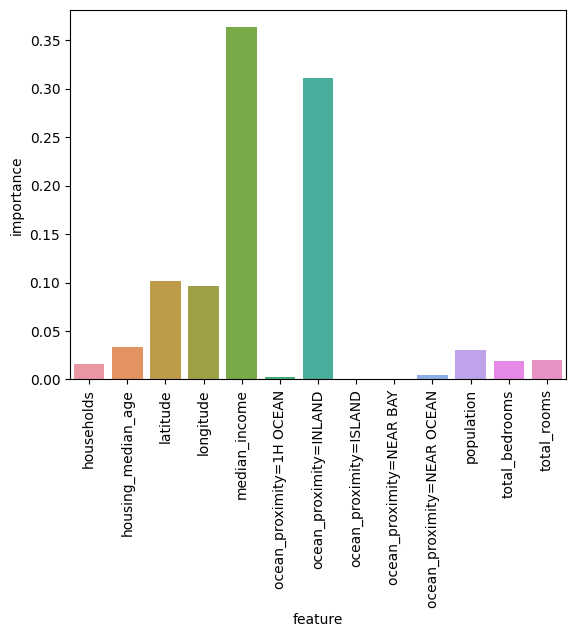

In [28]:
sns.barplot(x=df_feature_importance.feature, y=df_feature_importance.importance)
plt.xticks(rotation=90)
plt.show()

### Question 6

In [29]:
import xgboost as xgb

In [30]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

In [31]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [36]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)

[0]	train-rmse:8.12733	val-rmse:8.13245
[10]	train-rmse:0.34481	val-rmse:0.35782
[20]	train-rmse:0.21580	val-rmse:0.24624
[30]	train-rmse:0.19440	val-rmse:0.23741
[40]	train-rmse:0.17983	val-rmse:0.23419
[50]	train-rmse:0.16934	val-rmse:0.23097
[60]	train-rmse:0.16177	val-rmse:0.22950
[70]	train-rmse:0.15323	val-rmse:0.22787
[80]	train-rmse:0.14564	val-rmse:0.22611
[90]	train-rmse:0.13892	val-rmse:0.22628
[99]	train-rmse:0.13299	val-rmse:0.22610


In [37]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)

[0]	train-rmse:10.44372	val-rmse:10.44938
[10]	train-rmse:3.65741	val-rmse:3.66135
[20]	train-rmse:1.30499	val-rmse:1.31054
[30]	train-rmse:0.51144	val-rmse:0.52189
[40]	train-rmse:0.27984	val-rmse:0.30053
[50]	train-rmse:0.22614	val-rmse:0.25334
[60]	train-rmse:0.21035	val-rmse:0.24189
[70]	train-rmse:0.20116	val-rmse:0.23684
[80]	train-rmse:0.19384	val-rmse:0.23398
[90]	train-rmse:0.18794	val-rmse:0.23206
[99]	train-rmse:0.18329	val-rmse:0.23054
